#### Note - The following notebook contains the code solutions for all questions (except 1, 4 and 5). For any theoretical explanation of the code, please refer to the PDF attached along with the submission

This notebook explores the use of deep learning models to predict the operating mode of a wind turbine based on the two time series from the sensors used in the turbine's operation  

The data are sensor readings and operating modes for 4,000 turbine runs. time_series_1 and
time_series_2 are NumPy arrays of shape (4000,5000). Each observation corresponds to 5,000
records of the turbine over time by one of the two sensors (time_series_1 measures the pitch
angle in each second of operation, and time_series_2 measures the generator torque). y is the
operating mode for each of the 4,000 turbine runs (0 if the turbine is healthy, 1 if the generator
torque is faulty, 2 if the pitch angle is faulty, and 3 if both are faulty). Note that the dataset is
balanced in that each operating mode is represented equally often.

In [1]:
#loading relevant libraries

import numpy as np
import pickle
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [3]:
#importing the time series data of the wind turbines

with open('time_series_1.pickle','rb') as handle:
    time_series_1 = pickle.load(handle)
with open('time_series_2.pickle','rb') as handle:
    time_series_2 = pickle.load(handle)
with open('y.pickle','rb') as handle:
    y = pickle.load(handle)

In [4]:
#checking the data shapes

print(time_series_1.shape)
print(time_series_2.shape)
print(y.shape)

(4000, 5000)
(4000, 5000)
(4000,)


In [5]:
#combining time_series_1 and time_series_2, in the format [batch size, number of time steps, features]

time_series = np.dstack([time_series_1,time_series_2])
time_series.shape

(4000, 5000, 2)

In [6]:
#convert the y label into dummies (one hot encoding) so that they can be used s categorical labels for the models below

y_dummies = tf.keras.utils.to_categorical(y, num_classes=4)
y_dummies.shape

(4000, 4)

In [7]:
#create training (70%), validation (15%) and test set (15%)

X_train, X_other, y_train, y_others = train_test_split(time_series, y_dummies, train_size=0.7, random_state = 123)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_others, train_size=0.5,random_state = 123 )

#check the shape of the data sets

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(2800, 5000, 2)
(2800, 4)
(600, 5000, 2)
(600, 4)
(600, 5000, 2)
(600, 4)


#### Q2. Create an Iterator that produces batches of data formatted in the appropriate way for your chosen approach

In [8]:
#Combining labels and features into a single dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [9]:
train_dataset.element_spec #Checking what our data contains

(TensorSpec(shape=(5000, 2), dtype=tf.uint8, name=None),
 TensorSpec(shape=(4,), dtype=tf.float32, name=None))

In [10]:
#Shuffle and batch our training dataset, along with assigning batch sizes for validation and test datasets

batch_size = 20
shuffle_buffer_size = 100

train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [11]:
#Checking how the data is returned

for item in train_dataset:
    print("x-shape: " + str(item[0].shape) + " | y-shape:" + str(item[1].shape))
    break

x-shape: (20, 5000, 2) | y-shape:(20, 4)


In [12]:
#Prefetching the data

train_dataset = train_dataset.prefetch(1)
val_dataset = val_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)

#### Q3. Create a neural network in TensorFlow to predict the operating mode of a wind turbine based on the sensor data. Make sure that you try out different layers and elements discussed in class, such as Dense, SimpleRNN, GRU, and Conv1D

In [13]:
#Model 1 (Baseline Model) - Simple feed forward network with 4 dense layers and softmax activation function for output.

input_shape = (5000,2)
num_classes = 4

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(256, activation="relu"), #256 neurons in the 1st layer
    tf.keras.layers.Dense(128, activation="relu"), #128 neurons in the 2nd layer
    tf.keras.layers.Dense(4, activation="softmax") #4 neurons (for 4 classes) with softmax activation function
])

# Print the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 256)               2560256   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2,593,668
Trainable params: 2,593,668
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
loss_fn = tf.keras.losses.CategoricalCrossentropy()
model_1.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [15]:
#Fitting the training model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
log_1 = model_1.fit(train_dataset, epochs=20,
                    validation_data=val_dataset,callbacks=[early_stop])

Epoch 1/20
140/140 [==============================] - 8s 20ms/step - loss: 207.6533 - accuracy: 0.4079 - val_loss: 28.3250 - val_accuracy: 0.3433
Epoch 2/20
140/140 [==============================] - 2s 14ms/step - loss: 31.9218 - accuracy: 0.5679 - val_loss: 20.3921 - val_accuracy: 0.5167
Epoch 3/20
140/140 [==============================] - 1s 10ms/step - loss: 9.9769 - accuracy: 0.7382 - val_loss: 21.1560 - val_accuracy: 0.6033
Epoch 4/20
140/140 [==============================] - 1s 8ms/step - loss: 18.9443 - accuracy: 0.6493 - val_loss: 23.2498 - val_accuracy: 0.4667
Epoch 5/20
140/140 [==============================] - 1s 8ms/step - loss: 7.1894 - accuracy: 0.7600 - val_loss: 4.5552 - val_accuracy: 0.9000
Epoch 6/20
140/140 [==============================] - 1s 4ms/step - loss: 2.7760 - accuracy: 0.8357 - val_loss: 4.6282 - val_accuracy: 0.8500
Epoch 7/20
140/140 [==============================] - 1s 4ms/step - loss: 4.6926 - accuracy: 0.7611 - val_loss: 5.3556 - val_accuracy: 0.

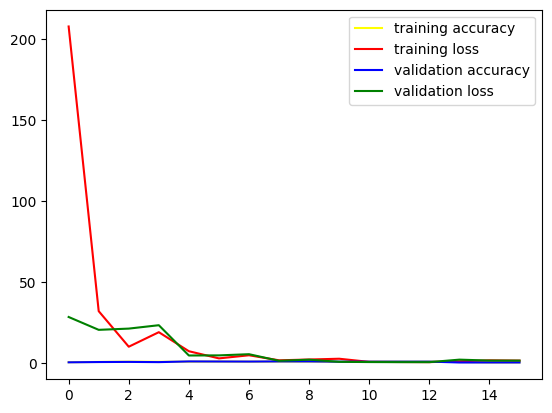

In [16]:
def create_plot(log_1):
    plt.plot(log_1.history['accuracy'],label = "training accuracy",color='yellow')
    plt.plot(log_1.history['loss'],label = "training loss",color='red')
    plt.plot(log_1.history['val_accuracy'], label = "validation accuracy",color='blue')
    plt.plot(log_1.history['val_loss'], label = "validation loss",color='green')
    plt.legend()
    plt.show()
create_plot(log_1)

In [17]:
#Accuracy numbers on test data

base_test_accuracy = model_1.evaluate(test_dataset)
base_valid_accuracy = model_1.evaluate(val_dataset)
print(base_test_accuracy)
print(base_valid_accuracy)

30/30 [==============================] - 0s 4ms/step - loss: 0.4462 - accuracy: 0.7767
[0.45887690782546997, 0.7950000166893005]
[0.44618305563926697, 0.7766666412353516]


In [18]:
#Model 2 - GRU - 2 layers followed by 2 dense layers (hybrid model using both sequence to sequence and sequence to vector approach)

model_2 = Sequential([
    GRU(70, return_sequences=True,activation = "tanh", input_shape=[None, 2]), #The input sequence has been defined to contain variable length so that each time step contains the readings at a specific point of time 
    GRU(140,activation = "tanh"),  
    Dense(50, activation='relu'),
    Dense(4, activation = "softmax")
])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 70)          15540     
                                                                 
 gru_1 (GRU)                 (None, 140)               89040     
                                                                 
 dense_3 (Dense)             (None, 50)                7050      
                                                                 
 dense_4 (Dense)             (None, 4)                 204       
                                                                 
Total params: 111,834
Trainable params: 111,834
Non-trainable params: 0
_________________________________________________________________


In [19]:
#fit GRU model on our training and validation set

def train_and_plot(model, learning_rate = 0.002, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",
                    optimizer=Adam(learning_rate = learning_rate),
                    metrics = ['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model.fit(train_dataset, epochs=epochs,
                    validation_data = val_dataset,
                    callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()

    return model

Epoch 1/20
140/140 [==============================] - 53s 339ms/step - loss: 1.3510 - accuracy: 0.3289 - val_loss: 1.2645 - val_accuracy: 0.3817
Epoch 2/20
140/140 [==============================] - 45s 321ms/step - loss: 1.2317 - accuracy: 0.4293 - val_loss: 1.1442 - val_accuracy: 0.4683
Epoch 3/20
140/140 [==============================] - 42s 299ms/step - loss: 1.0594 - accuracy: 0.5368 - val_loss: 0.9721 - val_accuracy: 0.5867
Epoch 4/20
140/140 [==============================] - 41s 292ms/step - loss: 0.8447 - accuracy: 0.6396 - val_loss: 0.7127 - val_accuracy: 0.6933
Epoch 5/20
140/140 [==============================] - 40s 286ms/step - loss: 0.6373 - accuracy: 0.7404 - val_loss: 0.5533 - val_accuracy: 0.7700
Epoch 6/20
140/140 [==============================] - 41s 295ms/step - loss: 0.5458 - accuracy: 0.7882 - val_loss: 0.5375 - val_accuracy: 0.7617
Epoch 7/20
140/140 [==============================] - 40s 289ms/step - loss: 0.4377 - accuracy: 0.8236 - val_loss: 0.4501 - val_ac

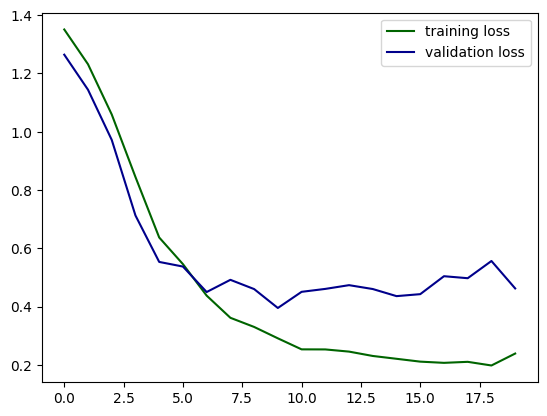

In [20]:
train_and_plot(model_2)

In [21]:
#evaluate the GRU model on the validation set

GRU_valid_accuracy = model_2.evaluate(val_dataset)
print(GRU_valid_accuracy)

30/30 [==============================] - 3s 108ms/step - loss: 0.3953 - accuracy: 0.8233
[0.39528584480285645, 0.8233333230018616]


In [22]:
#evaluate the GRU model on the test set
GRU_test_accuracy = model_2.evaluate(test_dataset)
print(GRU_test_accuracy)

30/30 [==============================] - 4s 133ms/step - loss: 0.4264 - accuracy: 0.8200
[0.42641589045524597, 0.8199999928474426]


In [23]:
#Model 3 - 3 Convolution 1D (no padding) layers + 2 GRU layers + 1 Dense layer (hybrid model using both sequence to sequence and sequence to vector approach)
model_3 = Sequential([
    Conv1D(filters=20,kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]), #20 filters across all the three convolutional layers
    Conv1D(filters=20,kernel_size=4, strides=2, padding="valid"),
    Conv1D(filters=20,kernel_size=4, strides=2, padding="valid"),
    GRU(70, return_sequences = True,activation = "tanh"),
    GRU(140, activation = 'tanh'),
    Dense(4,activation='softmax')])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 20)          1620      
                                                                 
 gru_2 (GRU)                 (None, None, 70)          19320     
                                                                 
 gru_3 (GRU)                 (None, 140)               89040     
                                                                 
 dense_5 (Dense)             (None, 4)                 564       
                                                                 
Total params: 112,344
Trainable params: 112,344
Non-tr

In [24]:
# Define train_plot_rnn for Convolutional 1D + GRU model 

def train_plot_cnn(model_cnn , learning_rate = 0.002, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_cnn.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_cnn.fit(train_dataset, epochs=epochs,
                        validation_data=val_dataset,
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_cnn

Epoch 1/20
140/140 [==============================] - 18s 56ms/step - loss: 1.0461 - accuracy: 0.5354 - val_loss: 0.5895 - val_accuracy: 0.7817
Epoch 2/20
140/140 [==============================] - 7s 49ms/step - loss: 0.4640 - accuracy: 0.8086 - val_loss: 0.4129 - val_accuracy: 0.8317
Epoch 3/20
140/140 [==============================] - 6s 42ms/step - loss: 0.3630 - accuracy: 0.8529 - val_loss: 0.4394 - val_accuracy: 0.7700
Epoch 4/20
140/140 [==============================] - 7s 49ms/step - loss: 0.2757 - accuracy: 0.8789 - val_loss: 0.3621 - val_accuracy: 0.8233
Epoch 5/20
140/140 [==============================] - 6s 42ms/step - loss: 0.2548 - accuracy: 0.8893 - val_loss: 0.3769 - val_accuracy: 0.8400
Epoch 6/20
140/140 [==============================] - 7s 53ms/step - loss: 0.2367 - accuracy: 0.8975 - val_loss: 0.4035 - val_accuracy: 0.8083
Epoch 7/20
140/140 [==============================] - 6s 42ms/step - loss: 0.2239 - accuracy: 0.8950 - val_loss: 0.3756 - val_accuracy: 0.833

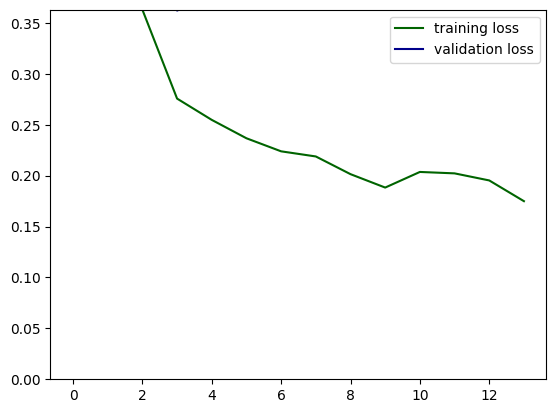

In [25]:
# Run train_plot_rnn of Convolutional 1D + GRU model 

train_plot_cnn(model_3)

In [26]:
# Evaluate Convolutional 1D + GRU + Dense model

cd_gru_test_accuracy = model_3.evaluate(test_dataset,verbose=0)
cd_gru_valid_accuracy = model_3.evaluate(val_dataset,verbose=0)
print(cd_gru_test_accuracy)
print(cd_gru_valid_accuracy)

[0.3891808092594147, 0.7983333468437195]
[0.36213335394859314, 0.8233333230018616]


In [27]:
#Model 4 - 3 Conv1D layers + 2 LSTM layers and a dense layer (hybrid model using both sequence to sequence and sequence to vector approach)

model_4 = Sequential([
    Conv1D(filters=20,kernel_size=3, strides=2, padding="valid", input_shape=[None, 2]), #20 filters in each convolutional layer
    Conv1D(filters=20,kernel_size=3, strides=2, padding="valid"),
    Conv1D(filters=20,kernel_size=3, strides=2, padding="valid"),
    LSTM(64, return_sequences = True,activation = "tanh"),
    LSTM(64, activation = "tanh"),
    Dense(4,activation='softmax')
    ])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 20)          140       
                                                                 
 conv1d_4 (Conv1D)           (None, None, 20)          1220      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 20)          1220      
                                                                 
 lstm (LSTM)                 (None, None, 64)          21760     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 4)                 260       
                                                                 
Total params: 57,624
Trainable params: 57,624
Non-trai

In [28]:
# Define Conv1D + LSTM + Dense train_plot

def train_plot_LSTM(model_lstm , learning_rate = 0.002, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_lstm.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_lstm.fit(train_dataset, epochs=epochs,
                    validation_data=val_dataset,
                    callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_lstm

Epoch 1/20
140/140 [==============================] - 15s 62ms/step - loss: 1.3474 - accuracy: 0.3157 - val_loss: 1.1632 - val_accuracy: 0.4467
Epoch 2/20
140/140 [==============================] - 6s 39ms/step - loss: 1.0391 - accuracy: 0.5329 - val_loss: 0.8334 - val_accuracy: 0.6883
Epoch 3/20
140/140 [==============================] - 6s 44ms/step - loss: 0.6380 - accuracy: 0.7407 - val_loss: 0.5057 - val_accuracy: 0.8000
Epoch 4/20
140/140 [==============================] - 6s 43ms/step - loss: 0.4312 - accuracy: 0.8361 - val_loss: 0.4720 - val_accuracy: 0.7983
Epoch 5/20
140/140 [==============================] - 7s 48ms/step - loss: 0.3283 - accuracy: 0.8718 - val_loss: 0.3423 - val_accuracy: 0.8617
Epoch 6/20
140/140 [==============================] - 5s 39ms/step - loss: 0.2847 - accuracy: 0.8821 - val_loss: 0.4350 - val_accuracy: 0.8083
Epoch 7/20
140/140 [==============================] - 7s 48ms/step - loss: 0.2919 - accuracy: 0.8779 - val_loss: 0.3729 - val_accuracy: 0.841

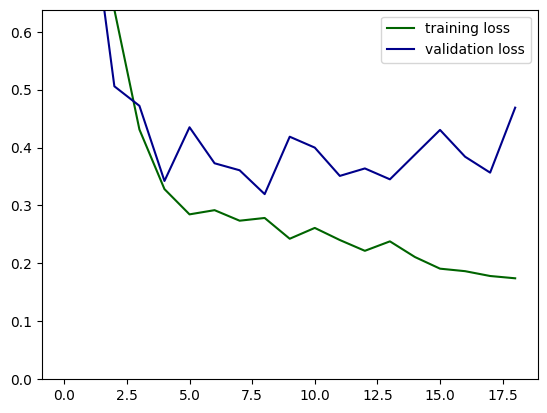

In [29]:
# Run train_plot_LSTM

train_plot_LSTM(model_4)

In [30]:
# Evaluate on Conv1D + LSTM model

lstm_test_accuracy = model_4.evaluate(test_dataset,verbose=0)
lstm_valid_accuracy = model_4.evaluate(val_dataset,verbose=0)
print(lstm_test_accuracy)
print(lstm_valid_accuracy)

[0.35961437225341797, 0.8516666889190674]
[0.31961312890052795, 0.8666666746139526]


In [31]:
#compare the results of Model 1, 2, 3 and 4

print("The validation set accuracy of Baseline model is", round(base_valid_accuracy[1], 3))
print("The validation loss in Baseline model is", round(base_valid_accuracy[0], 3))
print("----------------------")
print("The validation set accuracy of GRU model is", round(GRU_valid_accuracy[1], 3))
print("The validation loss in GRU model is", round(GRU_valid_accuracy[0], 3))
print("----------------------")
print("The validation set accuracy of Conv1D + GRU model is", round(cd_gru_valid_accuracy[1], 3))
print("The validation loss in Conv1D + GRU model is", round(cd_gru_valid_accuracy[0], 3))
print("----------------------")
print("The validation set accuracy of Conv1D + LSTM model is", round(lstm_valid_accuracy[1], 3))
print("The validation loss in Conv 1D + LSTM model is", round(lstm_valid_accuracy[0], 3))

The validation set accuracy of Baseline model is 0.777
The validation loss in Baseline model is 0.446
----------------------
The validation set accuracy of GRU model is 0.823
The validation loss in GRU model is 0.395
----------------------
The validation set accuracy of Conv1D + GRU model is 0.823
The validation loss in Conv1D + GRU model is 0.362
----------------------
The validation set accuracy of Conv1D + LSTM model is 0.867
The validation loss in Conv 1D + LSTM model is 0.32


#### Q6. Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a grayscale image). 

In [32]:
## convert time-series to a grey-scale image
num_classes = 4
img_rows, img_cols, img_channels = 100, 100, 1 # input image dimensions

# convert data type
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_valid = X_valid.astype('float32')

Y_train = y_train
Y_test = y_test
Y_valid = y_valid

In [33]:
# convert the 2 time series into a single array

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], img_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_channels, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

print('x_train shape:', x_train[0].shape)
print('Y_train shape:', Y_train[0].shape)


x_train shape: (100, 100, 1)
Y_train shape: (4,)


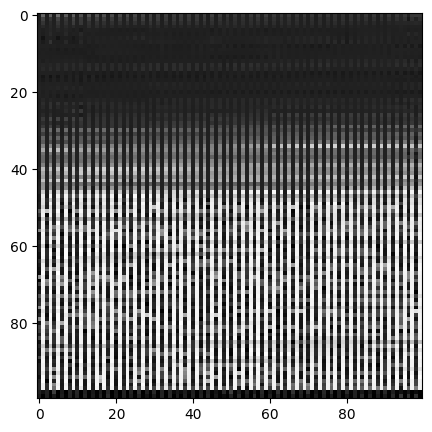

In [34]:
# Plot the figure

plt.figure(figsize=(5, 5))
plt.imshow(x_train[0].astype(int),cmap="Greys_r")
plt.show()

#### Q7. In TensorFlow, replicate the CNN with three convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy.

In [35]:
#Model 5 - Replicating figure 12 which has a CNN architecture of 3 convolutional layers, 1 dropout layer, 1 max pooling and 1 Fully Connected layer

model_5 = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=['accuracy'])
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                      

In [36]:
#fit the CNN model on our training and validation data

def train_and_plot2(model_cnn1, learning_rate = 0.002, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)
    model_cnn1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_cnn1.fit(x_train,Y_train,batch_size=20, 
                    validation_data = (x_valid,Y_valid),
                    epochs=epochs,callbacks = [early_stopping_cb])
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    return model_cnn1

Epoch 1/20
140/140 [==============================] - 4s 8ms/step - loss: 5.9792 - accuracy: 0.2650 - val_loss: 1.3852 - val_accuracy: 0.2700
Epoch 2/20
140/140 [==============================] - 1s 6ms/step - loss: 1.3397 - accuracy: 0.2879 - val_loss: 1.2429 - val_accuracy: 0.3917
Epoch 3/20
140/140 [==============================] - 1s 5ms/step - loss: 1.1920 - accuracy: 0.3975 - val_loss: 1.1637 - val_accuracy: 0.4367
Epoch 4/20
140/140 [==============================] - 1s 5ms/step - loss: 1.1448 - accuracy: 0.4354 - val_loss: 1.0905 - val_accuracy: 0.4367
Epoch 5/20
140/140 [==============================] - 1s 6ms/step - loss: 1.0983 - accuracy: 0.4618 - val_loss: 1.0686 - val_accuracy: 0.4750
Epoch 6/20
140/140 [==============================] - 1s 6ms/step - loss: 1.0716 - accuracy: 0.4689 - val_loss: 1.0939 - val_accuracy: 0.4867
Epoch 7/20
140/140 [==============================] - 1s 5ms/step - loss: 1.0248 - accuracy: 0.4989 - val_loss: 0.9868 - val_accuracy: 0.5600
Epoch 

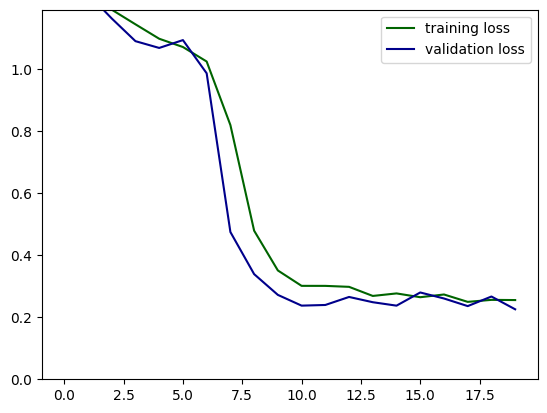

In [37]:
train_and_plot2(model_5)

In [38]:
#evaluate the model on the validation set

model_5_validation = model_5.evaluate(x_valid,Y_valid)

19/19 [==============================] - 0s 9ms/step - loss: 0.2257 - accuracy: 0.9000


In [39]:
#evaluate the model on the test dataset

model_5_test = model_5.evaluate(x_test,Y_test)

19/19 [==============================] - 0s 4ms/step - loss: 0.2830 - accuracy: 0.8933


#### Q8. Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.

In [40]:
#Model 6 - Using pretrained MobileNet model

# CNN model using pre-trained MobileNet model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from pandas._libs.lib import fast_unique_multiple_list_gen

# pre-process the training and test data for using in the MobileNet architecture

x_preprocess_train = preprocess_input(x_train.copy())
x_preprocess_test = preprocess_input(x_test.copy())
x_preprocess_valid = preprocess_input(x_valid.copy())
print(x_preprocess_train.shape, x_preprocess_test.shape,x_preprocess_valid.shape )

(2800, 100, 100, 1) (600, 100, 100, 1) (600, 100, 100, 1)


In [41]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (100,100,3))
mobilenet.trainable = False

# Un-Freeze the first 60 layers in the base model

for layer in mobilenet.layers[:60]:
    layer.trainable = True

model_6 = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
model_6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model_6.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 64)                65600     
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                       

Epoch 1/20
140/140 [==============================] - 7s 25ms/step - loss: 1.3793 - accuracy: 0.4089 - val_loss: 1.4624 - val_accuracy: 0.2600
Epoch 2/20
140/140 [==============================] - 2s 17ms/step - loss: 0.8607 - accuracy: 0.6546 - val_loss: 1.1161 - val_accuracy: 0.5083
Epoch 3/20
140/140 [==============================] - 2s 17ms/step - loss: 0.6437 - accuracy: 0.7686 - val_loss: 0.6607 - val_accuracy: 0.7550
Epoch 4/20
140/140 [==============================] - 2s 18ms/step - loss: 0.5323 - accuracy: 0.8154 - val_loss: 0.5217 - val_accuracy: 0.8000
Epoch 5/20
140/140 [==============================] - 3s 19ms/step - loss: 0.4539 - accuracy: 0.8404 - val_loss: 0.4688 - val_accuracy: 0.8250
Epoch 6/20
140/140 [==============================] - 2s 18ms/step - loss: 0.4009 - accuracy: 0.8661 - val_loss: 0.4554 - val_accuracy: 0.8267
Epoch 7/20
140/140 [==============================] - 3s 18ms/step - loss: 0.3643 - accuracy: 0.8757 - val_loss: 0.4199 - val_accuracy: 0.8433

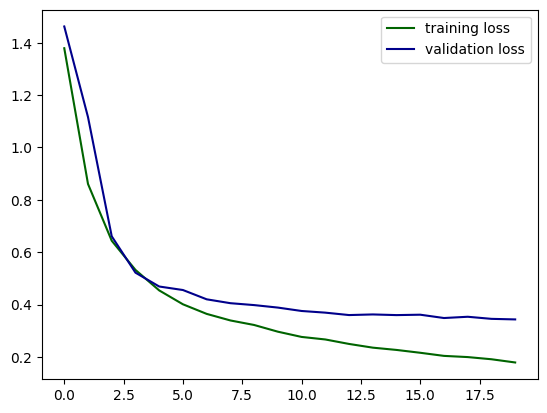

In [42]:
#fit the mobilenet model on our training and validation data
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
log_2 = model_6.fit(x_preprocess_train,Y_train,
                    validation_data = (x_preprocess_valid,Y_valid),
                    batch_size = 20,
                    epochs=20,callbacks = [early_stopping_cb])

plt.plot(log_2.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_2.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

In [43]:
#evaluate the model on the validation set

model_6_validation = model_6.evaluate(x_preprocess_valid, Y_valid)

19/19 [==============================] - 1s 25ms/step - loss: 0.3431 - accuracy: 0.8600


In [44]:
#evaluate the model on the test set

model_6_test = model_6.evaluate(x_preprocess_test, y_test)

19/19 [==============================] - 0s 12ms/step - loss: 0.3475 - accuracy: 0.8667


In [45]:
#Model 7 - Using pretrained InceptionV3 model

# CNN model with pretrained InceptionV3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape = (100,100,3))
InceptionV3.trainable = False

model_7 = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    InceptionV3,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
model_7.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=['accuracy'])
model_7.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 100, 100, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 64)                131136    
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 21,934,210
Trainable params: 131,426
Non-

Epoch 1/20
140/140 [==============================] - 15s 52ms/step - loss: 0.9589 - accuracy: 0.5746 - val_loss: 0.7299 - val_accuracy: 0.6733
Epoch 2/20
140/140 [==============================] - 5s 35ms/step - loss: 0.6051 - accuracy: 0.7579 - val_loss: 0.5745 - val_accuracy: 0.7683
Epoch 3/20
140/140 [==============================] - 6s 40ms/step - loss: 0.5020 - accuracy: 0.8046 - val_loss: 0.4799 - val_accuracy: 0.8150
Epoch 4/20
140/140 [==============================] - 5s 36ms/step - loss: 0.4260 - accuracy: 0.8264 - val_loss: 0.4327 - val_accuracy: 0.8383
Epoch 5/20
140/140 [==============================] - 5s 36ms/step - loss: 0.3947 - accuracy: 0.8393 - val_loss: 0.4078 - val_accuracy: 0.8367
Epoch 6/20
140/140 [==============================] - 5s 38ms/step - loss: 0.3731 - accuracy: 0.8489 - val_loss: 0.3864 - val_accuracy: 0.8550
Epoch 7/20
140/140 [==============================] - 5s 36ms/step - loss: 0.3226 - accuracy: 0.8721 - val_loss: 0.4074 - val_accuracy: 0.853

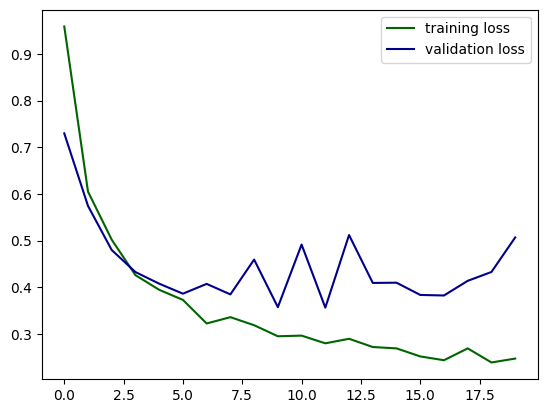

In [46]:
#fit the InceptionV3 model on our training and validation data
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
log_3 = model_7.fit(x_preprocess_train, Y_train,
                      validation_data = (x_preprocess_valid,Y_valid),
                      batch_size=20,
                      epochs=20,callbacks = [early_stopping_cb])

plt.plot(log_3.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_3.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

In [47]:
#evaluate the model on the validation set
model_7_validation = model_7.evaluate(x_preprocess_valid, Y_valid)

19/19 [==============================] - 4s 67ms/step - loss: 0.5069 - accuracy: 0.8233


In [48]:
#evaluate the model on the test set
model_7_test = model_7.evaluate(x_preprocess_test, Y_test)

19/19 [==============================] - 0s 21ms/step - loss: 0.5452 - accuracy: 0.8133


In [49]:
#compare all CNN models

print("The validation set accuracy of CNN model with 3 Convolutional layers is:", round(model_5_validation[1], 3))
print("The validation loss in CNN model with 3 Convolutional layers is:", round(model_5_validation[0], 3))
print("---------------------")
print("The validation set accuracy of mobilenet model is:", round(model_6_validation[1], 3))
print("The validation loss in mobilenet model is:", round(model_6_validation[0], 3))
print("---------------------")
print("The validation set accuracy of InceptionV3 model is;", round(model_7_validation[1], 3))
print("The validation loss in InceptionV3 model is;", round(model_7_validation[0], 3))

The validation set accuracy of CNN model with 3 Convolutional layers is: 0.9
The validation loss in CNN model with 3 Convolutional layers is: 0.226
---------------------
The validation set accuracy of mobilenet model is: 0.86
The validation loss in mobilenet model is: 0.343
---------------------
The validation set accuracy of InceptionV3 model is; 0.823
The validation loss in InceptionV3 model is; 0.507


As observed from the model performances, the CNN model with 3 layers (Model 5) has the best performance and can be used for the combined training and validation dataset. For a detailed explanation of the selection of the best model, refer to the PDF.

#### Q9. Compare the models you have created so far and select the best model (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set. Make sure to record your final test accuracy.

In [50]:
#combine training and validation set to allow the final training set to contain 85% of original data

X_train_valid = np.concatenate((X_train, X_valid))
Y_train_valid = np.concatenate((y_train, y_valid))

print(X_train_valid.shape)
print(Y_train_valid.shape)

(3400, 5000, 2)
(3400, 4)


In [51]:
#Since Model 5 has been performing the best, we need to convert the data to the same shape, as shown in Model 5

# input image dimensions
num_classes = 4
img_rows, img_cols, img_channels = 100, 100, 1 # the array shape that we want to convert our data to

# change the type of the current training and testing data
X_train_valid = X_train_valid.astype('float32')

# convert the X_train_valid into a single array 
if K.image_data_format() == 'channels_first':
    X_train_valid = X_train_valid.reshape(X_train_valid.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train_valid= X_train_valid.reshape(X_train_valid.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

print(X_train_valid[0].shape)

(100, 100, 1)


In [52]:
#fit the CNN model on our combined training and validation data

def train_and_plot3(model_cnn2, learning_rate = 0.001, epochs = 10):
    np.random.seed(312)
    tf.random.set_seed(312)
    model_cnn2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model_cnn2.fit(X_train_valid,Y_train_valid,batch_size=20, 
                    epochs=epochs,callbacks = [early_stopping_cb])
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    return model_cnn2

Epoch 1/10
165/170 [============================>.] - ETA: 0s - loss: 0.2919 - accuracy: 0.8876

170/170 [==============================] - 3s 6ms/step - loss: 0.2927 - accuracy: 0.8868
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8915

170/170 [==============================] - 1s 5ms/step - loss: 0.2685 - accuracy: 0.8915
Epoch 3/10
167/170 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8814

170/170 [==============================] - 1s 5ms/step - loss: 0.2729 - accuracy: 0.8815
Epoch 4/10
161/170 [===========================>..] - ETA: 0s - loss: 0.2516 - accuracy: 0.8953

170/170 [==============================] - 1s 5ms/step - loss: 0.2513 - accuracy: 0.8941
Epoch 5/10
168/170 [============================>.] - ETA: 0s - loss: 0.2425 - accuracy: 0.8961

170/170 [==============================] - 1s 5ms/step - loss: 0.2422 - accuracy: 0.8962
Epoch 6/10
166/170 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.8985

170/170 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.8982
Epoch 7/10
166/170 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.8949

170/170 [==============================] - 1s 6ms/step - loss: 0.2539 - accuracy: 0.8947
Epoch 8/10
167/170 [============================>.] - ETA: 0s - loss: 0.2424 - accuracy: 0.8940

170/170 [==============================] - 1s 8ms/step - loss: 0.2429 - accuracy: 0.8944
Epoch 9/10
169/170 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.8935

170/170 [==============================] - 1s 7ms/step - loss: 0.2385 - accuracy: 0.8938
Epoch 10/10
168/170 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.8961

170/170 [==============================] - 1s 7ms/step - loss: 0.2364 - accuracy: 0.8968


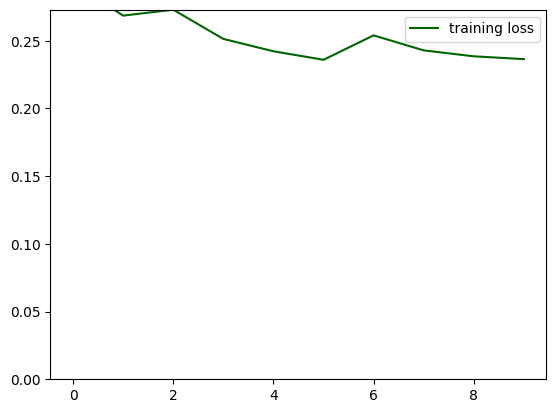

In [53]:
train_and_plot3(model_5)

In [54]:
#evaluate the model on the test set
model_5.evaluate(x_test, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 0.2481 - accuracy: 0.8950


[0.24811884760856628, 0.8949999809265137]

In [56]:
#Save the best model
model_5.save("best_model_final2.h5")